# Definição do framework

In [100]:
from CoolProp.CoolProp import PropsSI
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from CoolProp.Plots import PropertyPlot


class Experimento:

    # definindo funções de conversão
    @classmethod
    def celcius_to_kelvin(cls, T):
        return T + 273.15

    @classmethod
    def psi_to_pascal(cls, P, manometro=True):
        if manometro:
            return P * 6894 + 101325
        return P * 6894

    @classmethod
    def bar_to_pascal(cls, P, manometro=True):
        if manometro:
            return P * 100000 + 101325
        return P * 100000

    @classmethod
    def vasao(cls, prop1, prop2, Q):
        rho = PropsSI(
            "D", prop1["name"], prop1["value"], prop2["name"], prop2["value"], "R134a"
        )
        return Q * 1e-3 * rho / 3600

    def __init__(self, Temp_dict, Press_dict, I, Q, cool=True, correcao=False):
        # passando valores de temperatura
        self.Ts1 = self.celcius_to_kelvin(Temp_dict["Ts1"])
        self.Ts2 = self.celcius_to_kelvin(Temp_dict["Ts2"])
        self.Ts3 = self.celcius_to_kelvin(Temp_dict["Ts3"])
        self.Ts4 = self.celcius_to_kelvin(Temp_dict["Ts4"])

        # passando valores de pressão
        self.Ps1 = self.bar_to_pascal(Press_dict["Ps1"])
        self.Ps2 = self.bar_to_pascal(Press_dict["Ps2"])
        self.Ps3 = self.bar_to_pascal(Press_dict["Ps3"])

        # passando demais valores
        self.cool = cool
        self.I = I
        self.Q = Q

        # determinando entalpias
        if cool:
            self.Hs1 = PropsSI("H", "P", self.Ps1, "T", self.Ts1, "R134a")
            self.Hs2 = PropsSI("H", "P", self.Ps2, "T", self.Ts2, "R134a")
            self.Hs3 = PropsSI("H", "P", self.Ps3, "T", self.Ts3, "R134a")
            self.Hs4 = self.Hs3

            if correcao:
                self.Ps4 = self.Ps1
            
            else:
                self.Ps4 = self.bar_to_pascal(Press_dict["Ps4"])

            input_array = np.array(
                (
                    [self.Ts1, self.Ps1, self.Hs1, 1],
                    [self.Ts2, self.Ps2, self.Hs2, 2],
                    [self.Ts3, self.Ps3, self.Hs3, 3],
                    [self.Ts4, self.Ps4, self.Hs4, 4],
                )
            )

            self.input_df = pd.DataFrame(
                input_array,
                columns=["Temperatura", "Pressao", "Entalpia", "Ponto no bancada"],
            )

        else:
            self.Hs2 = PropsSI("H", "P", self.Ps2, "T", self.Ts2, "R134a")
            self.Hs1 = PropsSI("H", "P", self.Ps1, "T", self.Ts1, "R134a")
            self.Hs4 = PropsSI("H", "P", self.Ps4, "T", self.Ts4, "R134a")
            self.Hs3 = self.Hs4

            if correcao:
                self.Ps4 = self.Ps1

            else:
                self.Ps4 = self.bar_to_pascal(Press_dict["Ps4"])

            input_array = np.array(
                (
                    [self.Ts2, self.Ps2, self.Hs2, 2],
                    [self.Ts1, self.Ps1, self.Hs1, 1],
                    [self.Ts4, self.Ps4, self.Hs4, 4],
                    [self.Ts3, self.Ps3, self.Hs3, 3],
                )
            )

            self.input_df = pd.DataFrame(
                input_array,
                columns=["Temperatura", "Pressao", "Entalpia", "Ponto na bancada"],
            )

    def variacoes(self):

        if self.cool:
            self.delta_T_eva = self.Ts1 - self.Ts4
            self.delta_T_cond = self.Ts3 - self.Ts2

            self.delta_P_eva = self.Ps1 - self.Ps4
            self.delta_P_cond = self.Ps3 - self.Ps2

        else:
            self.delta_T_eva = self.Ts2 - self.Ts3
            self.delta_T_cond = self.Ts4 - self.Ts1

            self.delta_P_eva = self.Ps2 - self.Ps3
            self.delta_P_cond = self.Ps4 - self.Ps1

    def calc_COP(self):

        if self.cool:
            self.COP = (self.Hs1 - self.Hs4) / (self.Hs2 - self.Hs1)

        else:
            self.COP = (self.Hs4 - self.Hs1) / (self.Hs1 - self.Hs2)

    def calc_ef_isentropica(self):
        self.Ss1 = PropsSI('S','T', self.Ts1, 'P', self.Ps1,"R134a")
        self.Hs2s = PropsSI('H','S',self.Ss1,'P',self.Ps2,"R134a")

        self.ef_isentropica = (self.Hs2s-self.Hs1)/(self.Hs2-self.Hs1)

    def calc_trab_compressao(self):
        self.trab_compressao = self.dot_m * (self.Hs2-self.Hs1)

    def calc_potencia_compressor(self):
        self.pot_comp = self.I * 127

    def analise_defaut(self):

        self.variacoes()

        self.calc_COP()

        self.calc_ef_isentropica()
        
        self.calc_potencia_compressor()

        prop1 = {"name": "T", "value": self.Ts3}

        prop2 = {"name": "P", "value": self.Ps3}
        
        self.dot_m = self.vasao(prop1, prop2, self.Q)

        self.calc_trab_compressao()

        if self.cool:
            output_array = np.array(
                (
                    [
                        self.delta_T_eva,
                        self.delta_T_cond,
                        self.delta_P_eva,
                        self.delta_P_cond,
                        self.COP,
                        self.dot_m,
                        self.ef_isentropica,
                        self.trab_compressao,
                        self.pot_comp,
                    ]
                )
            )

            self.output_df = pd.DataFrame(
                output_array.reshape(1, len(output_array)),
                columns=[
                    "delta_T_eva",
                    "delta_T_cond",
                    "delta_P_eva",
                    "delta_P_cond",
                    "COP",
                    "dot_m",
                    'ef_isentropica',
                    "trab_compressao",
                    'pot_comp',
                ],
            )

        else:
            output_array = np.array(
                (
                    [
                        self.delta_T_eva,
                        self.delta_T_cond,
                        self.delta_P_eva,
                        self.delta_P_cond,
                        self.COP,
                        self.ef_isentropica,
                        self.trab_compressao,
                        self.pot_comp,
                    ]
                )
            )

            self.output_df = pd.DataFrame(
                output_array.reshape(1, len(output_array)),
                columns=[
                    "delta_T_eva",
                    "delta_T_cond",
                    "delta_P_eva",
                    "delta_P_cond",
                    "COP",
                    "ef_isentropica",
                    "trab_compressao",
                    "pot_comp",
                ],
            )

    def plot_diagrama_ph(self):
        ph_plot = PropertyPlot("R134a", "Ph")
        ph_plot.calc_isolines()
        fig = ph_plot.figure
        fig.set_size_inches(16, 9)
        ax = ph_plot.axis

        # definindo listas para fechar o ciclo
        plot_entalpia = self.input_df.Entalpia.to_list()
        plot_pressao = self.input_df.Pressao.to_list()

        plot_entalpia.append(self.input_df.Entalpia[0])
        plot_pressao.append(self.input_df.Pressao[0])

        plot_entalpia = [h / 10 ** 3 for h in plot_entalpia]
        plot_pressao = [h / 10 ** 3 for h in plot_pressao]

        ax.plot(
            plot_entalpia,
            plot_pressao,
            "o",
            plot_entalpia,
            plot_pressao,
            "-",
            color="b",
        )

        # anotando os pontos no diagrama

        if self.cool:
            ax.annotate(
                "S1",
                (
                    self.input_df.Entalpia[0] / 1e3 + 5,
                    self.input_df.Pressao[0] / 1e3 + 5,
                ),
            )
            ax.annotate(
                "S2",
                (
                    self.input_df.Entalpia[1] / 1e3 + 5,
                    self.input_df.Pressao[1] / 1e3 + 5,
                ),
            )
            ax.annotate(
                "S3",
                (
                    self.input_df.Entalpia[2] / 1e3 + 5,
                    self.input_df.Pressao[2] / 1e3 + 5,
                ),
            )
            ax.annotate(
                "S4",
                (
                    self.input_df.Entalpia[3] / 1e3 + 5,
                    self.input_df.Pressao[3] / 1e3 + 5,
                ),
            )
            ph_plot.show()

        else:
            ax.annotate(
                "S2",
                (
                    self.input_df.Entalpia[0] / 1e3 + 5,
                    self.input_df.Pressao[0] / 1e3 + 5,
                ),
            )
            ax.annotate(
                "S1",
                (
                    self.input_df.Entalpia[1] / 1e3 + 5,
                    self.input_df.Pressao[1] / 1e3 + 5,
                ),
            )
            ax.annotate(
                "S4",
                (
                    self.input_df.Entalpia[2] / 1e3 + 5,
                    self.input_df.Pressao[2] / 1e3 + 5,
                ),
            )
            ax.annotate(
                "S3",
                (
                    self.input_df.Entalpia[3] / 1e3 + 5,
                    self.input_df.Pressao[3] / 1e3 + 5,
                ),
            )
            ph_plot.show()

    def plot_P_saida_crompressor_vs_COP(self,min,max):
        if self.cool:
            P_list = np.linspace(min,max,250)
            original_Hs2 = self.Hs2
            S_ref = PropsSI('S','T',self.Ts2,'P',self.Ps2,"R134a")
            results_list = []
            for P in P_list:
                Ts2 = PropsSI('T','S',S_ref,'P',P,"R134a")
                self.Hs2 = PropsSI('H','T',Ts2,'P',P,"R134a")

                self.calc_COP()

                results_list.append(self.COP)

            # retornando valores originais

            self.Hs2 = original_Hs2
            self.calc_COP()

            # plotando resultados
            fig = plt.figure(figsize=[16, 9])

            # Plotando 2D

            ax = fig.add_subplot(1, 1, 1)

            ax.set_xlabel('$Ps2~[Pa]$',fontsize=16)
            ax.set_ylabel("$COP$",fontsize=16)

            ax.plot(P_list, results_list, 'r', linewidth=2)

            ax.grid()

            plt.show()

        else:
            print('not implemented')
        return

    def plot_P_saida_crompressor_vs_trab_compressao(self,min,max):
        if self.cool:
            P_list = np.linspace(min,max,250)
            original_Hs2 = self.Hs2
            S_ref = PropsSI('S','T',self.Ts2,'P',self.Ps2,"R134a")
            results_list = []
            for P in P_list:
                Ts2 = PropsSI('T','S',S_ref,'P',P,"R134a")
                self.Hs2 = PropsSI('H','T',Ts2,'P',P,"R134a")

                self.calc_trab_compressao()

                results_list.append(self.trab_compressao)

            # retornando valores originais

            self.Hs2 = original_Hs2
            self.calc_trab_compressao()

            # plotando resultados
            fig = plt.figure(figsize=[16, 9])

            # Plotando 2D

            ax = fig.add_subplot(1, 1, 1)

            ax.set_xlabel('$Ps2~[Pa]$',fontsize=16)
            ax.set_ylabel("$W_{comp}~[J/s]$",fontsize=16)

            ax.plot(P_list, results_list, 'r', linewidth=2)

            ax.grid()

            plt.show()

        else:
            print('not implemented')
        return

    def plot_P_saida_crompressor_vs_ef_isentropica(self,min,max):
        if self.cool:
            P_list = np.linspace(min,max,250)
            original_Hs2 = self.Hs2
            S_ref = PropsSI('S','T',self.Ts2,'P',self.Ps2,"R134a")
            results_list = []
            for P in P_list:
                Ts2 = PropsSI('T','S',S_ref,'P',P,"R134a")
                self.Hs2 = PropsSI('H','T',Ts2,'P',P,"R134a")

                self.calc_ef_isentropica()

                results_list.append(self.ef_isentropica)

            # retornando valores originais

            self.Hs2 = original_Hs2
            self.calc_ef_isentropica()

            # plotando resultados
            fig = plt.figure(figsize=[16, 9])

            # Plotando 2D

            ax = fig.add_subplot(1, 1, 1)

            ax.set_xlabel('$Ps2(Pa)$',fontsize=16)
            ax.set_ylabel("$\eta$",fontsize=16)

            ax.plot(P_list, results_list, 'r', linewidth=2)

            ax.grid()

            plt.show()

        else:
            print('not implemented')
        return


# Resultados sem correção

In [101]:
# definicao de dados experimentais
Temp1 = {
    'Ts1': 9,
    'Ts2': 54.5,
    'Ts3': 36,
    'Ts4': 9,
}

Press1 = {
    'Ps1': 2.5,
    'Ps2': 13.5,
    'Ps3': 12,
    'Ps4': 0.5,
}

I = 4.5

Q = 35


In [102]:
exp = Experimento(Temp1,Press1,I,Q)
exp.input_df

,Temperatura,Pressao,Entalpia,Ponto no bancada
0,282.15,351325.0,405114.051615,1.0
1,327.65,1451325.0,425584.692577,2.0
2,309.15,1301325.0,250433.802577,3.0
3,282.15,151325.0,250433.802577,4.0


In [103]:
exp.analise_defaut()
exp.output_df

,delta_T_eva,delta_T_cond,delta_P_eva,delta_P_cond,COP,dot_m,ef_isentropica,trab_compressao,pot_comp
0,0.0,-18.5,200000.0,-150000.0,7.5562,0.01134,1.470739,232.130889,571.5


/home/thiago/anaconda3/envs/default/lib/python3.9/site-packages/CoolProp/Plots/Common.py:655: UserWarning: An error occurred for inputs 8771670.263783, 2426.329225 with index (248,): unable to solve 1phase PY flash with Tmin=169.849, Tmax=682.5 due to error: HSU_P_flash_singlephase_Brent could not find a solution because Smolar [247.563 J/mol/K] is above the maximum value of 247.390746622 J/mol/K
  warnings.warn(
/home/thiago/anaconda3/envs/default/lib/python3.9/site-packages/CoolProp/Plots/Common.py:655: UserWarning: An error occurred for inputs 9133000.049092, 2426.329225 with index (249,): unable to solve 1phase PY flash with Tmin=169.849, Tmax=682.5 due to error: HSU_P_flash_singlephase_Brent could not find a solution because Smolar [247.563 J/mol/K] is above the maximum value of 246.954593629 J/mol/K
  warnings.warn(
/home/thiago/anaconda3/envs/default/lib/python3.9/site-packages/CoolProp/Plots/Common.py:655: UserWarning: An error occurred for inputs 1426198.569157, 2593.934527 wi

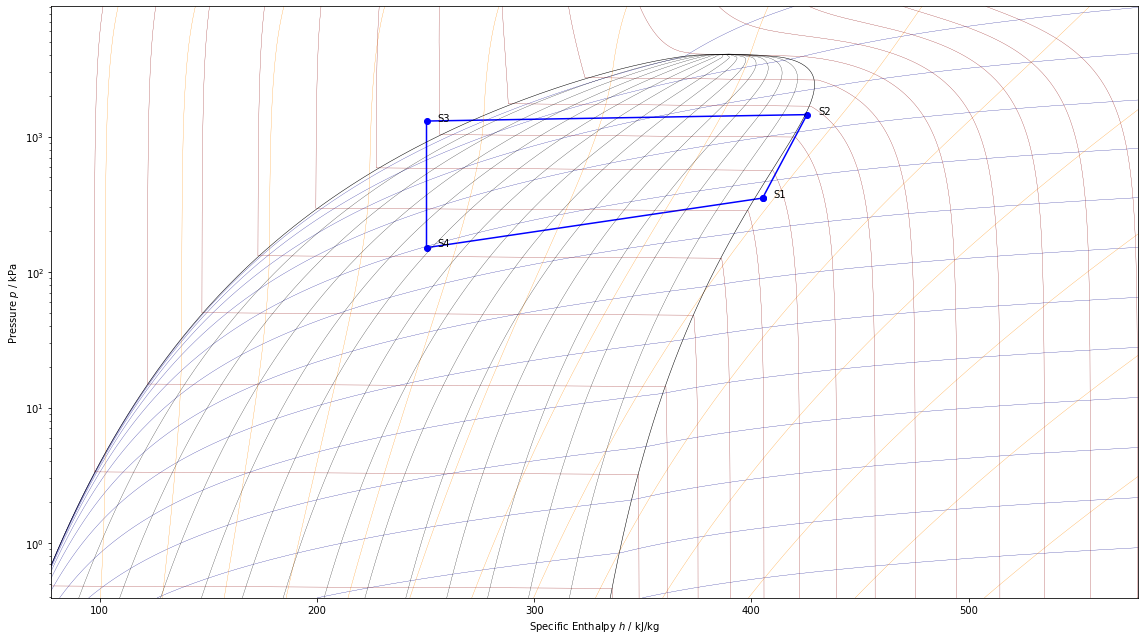

In [87]:
exp.plot_diagrama_ph()

# Resultados com correção

In [76]:
exp2 = Experimento(Temp1,Press1,I,Q,correcao=True)
exp2.input_df

,Temperatura,Pressao,Entalpia,Ponto no bancada
0,282.15,351325.0,405114.051615,1.0
1,327.65,1451325.0,425584.692577,2.0
2,309.15,1301325.0,250433.802577,3.0
3,282.15,351325.0,250433.802577,4.0


In [78]:
exp2.trab_compressao

AttributeError: 'Experimento' object has no attribute 'trab_compressao'

In [77]:
exp2.analise_defaut()
exp2.output_df

,delta_T_eva,delta_T_cond,delta_P_eva,delta_P_cond,COP,dot_m,ef_isentropica,pot_comp
0,0.0,-18.5,0.0,-150000.0,7.5562,40.822913,1.470739,571.5


/home/thiago/anaconda3/envs/default/lib/python3.9/site-packages/CoolProp/Plots/Common.py:655: UserWarning: An error occurred for inputs 8771670.263783, 2426.329225 with index (248,): unable to solve 1phase PY flash with Tmin=169.849, Tmax=682.5 due to error: HSU_P_flash_singlephase_Brent could not find a solution because Smolar [247.563 J/mol/K] is above the maximum value of 247.390746622 J/mol/K
  warnings.warn(
/home/thiago/anaconda3/envs/default/lib/python3.9/site-packages/CoolProp/Plots/Common.py:655: UserWarning: An error occurred for inputs 9133000.049092, 2426.329225 with index (249,): unable to solve 1phase PY flash with Tmin=169.849, Tmax=682.5 due to error: HSU_P_flash_singlephase_Brent could not find a solution because Smolar [247.563 J/mol/K] is above the maximum value of 246.954593629 J/mol/K
  warnings.warn(
/home/thiago/anaconda3/envs/default/lib/python3.9/site-packages/CoolProp/Plots/Common.py:655: UserWarning: An error occurred for inputs 1426198.569157, 2593.934527 wi

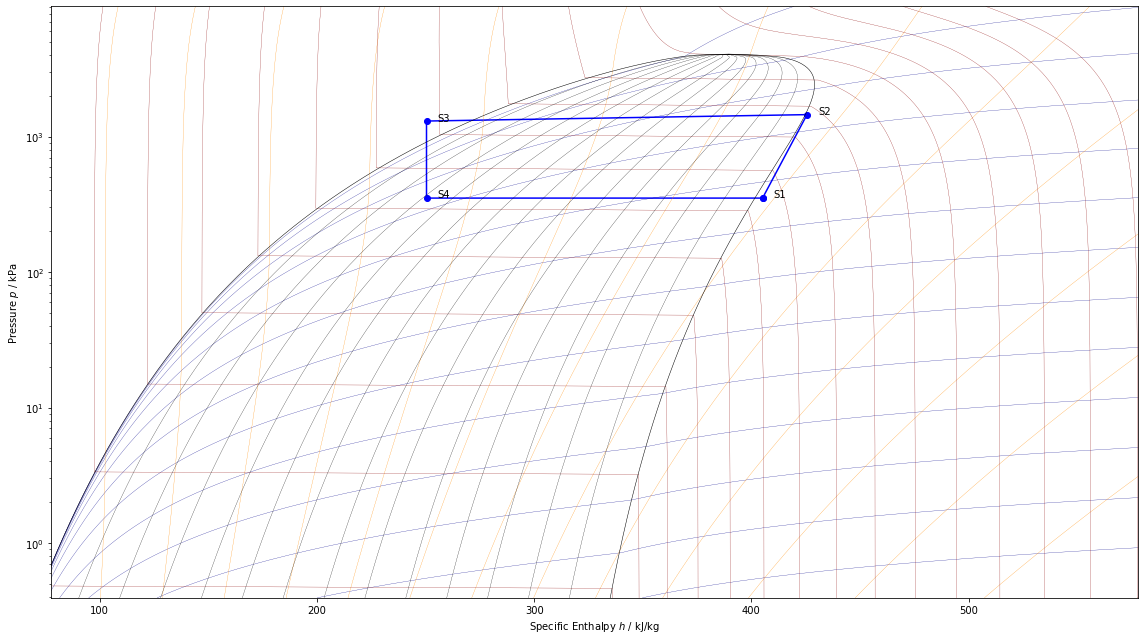

In [55]:
exp2.plot_diagrama_ph()

# Análise Gráfica

## P x COP

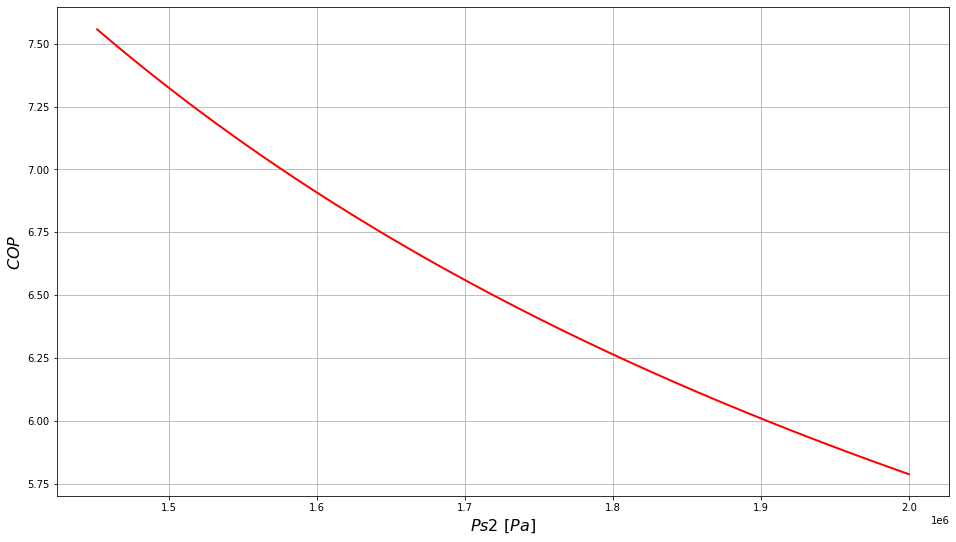

In [56]:
exp2.plot_P_saida_crompressor_vs_COP(1451325.0,0.2e7)

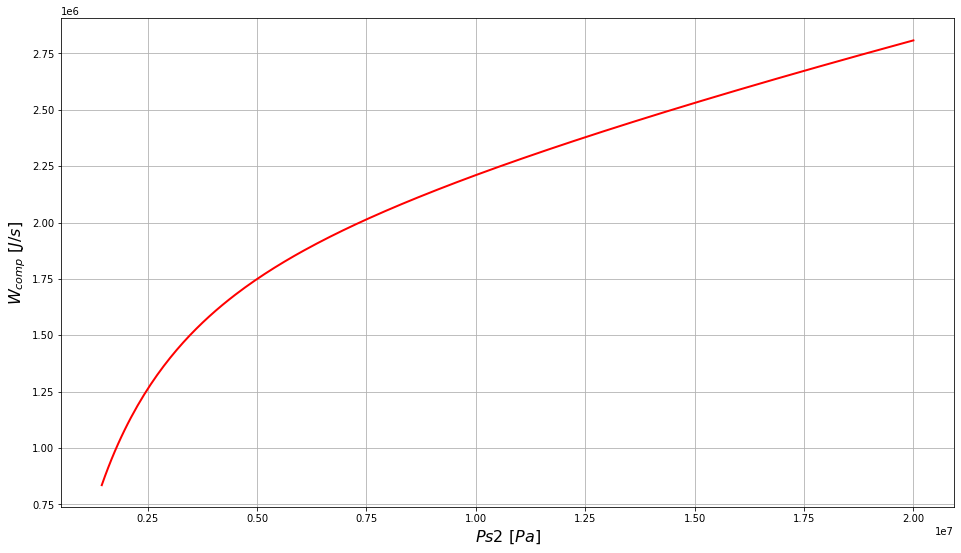

In [62]:
exp2.plot_P_saida_crompressor_vs_trab_compressao(1451325.0,0.2e8)


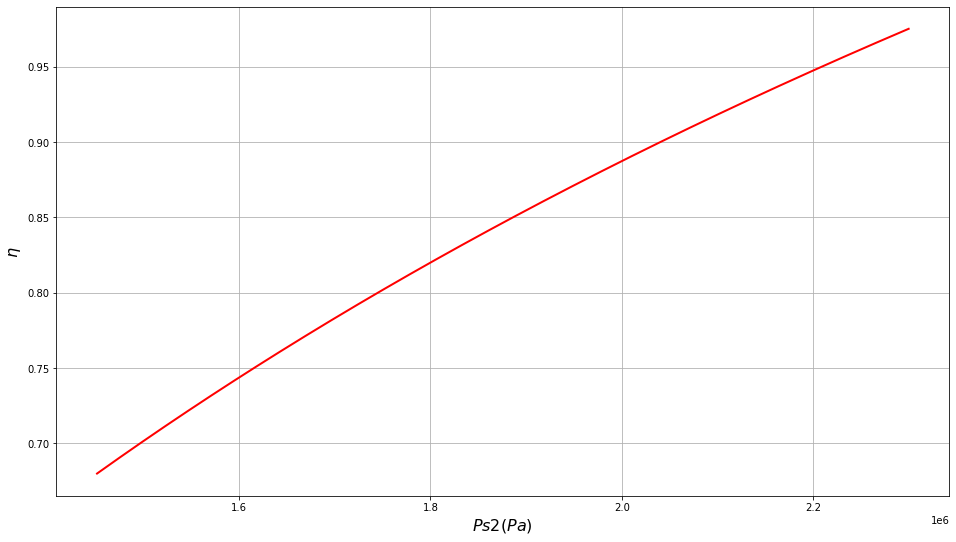

In [60]:
exp2.plot_P_saida_crompressor_vs_ef_isentropica(1451325.0,0.23e7)